<a href="https://colab.research.google.com/github/bdgroves/desert-ecostats/blob/main/DV_Python_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DEM Metadata: {'driver': 'GTiff', 'dtype': 'int16', 'nodata': None, 'width': 4269, 'height': 3113, 'count': 1, 'crs': CRS.from_wkt('PROJCS["WGS 84 / Pseudo-Mercator",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"],AUTHORITY["EPSG","3857"]]'), 'transform': Affine(90.0, 0.0, -13442488.3428,
       0.0, -89.99579177642138, 4668371.5775)}


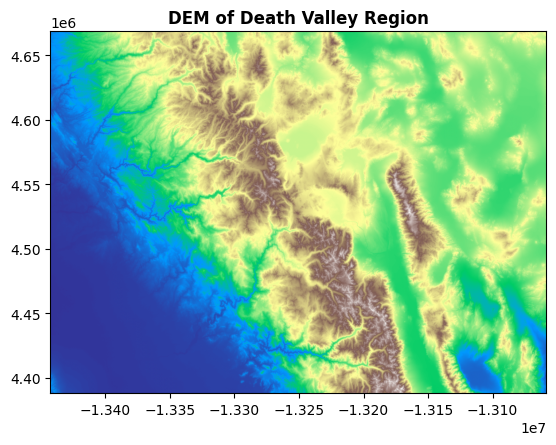

Reprojected DEM saved as: reprojected_dem.tif


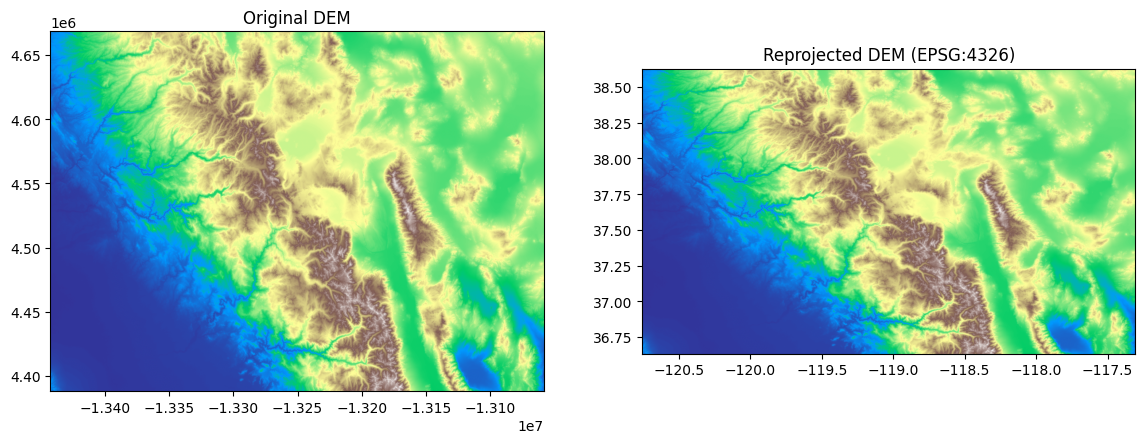

Multispectral image - Bands: 4
CRS: EPSG:4326


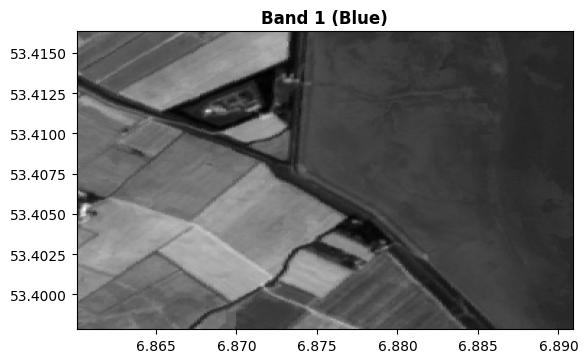

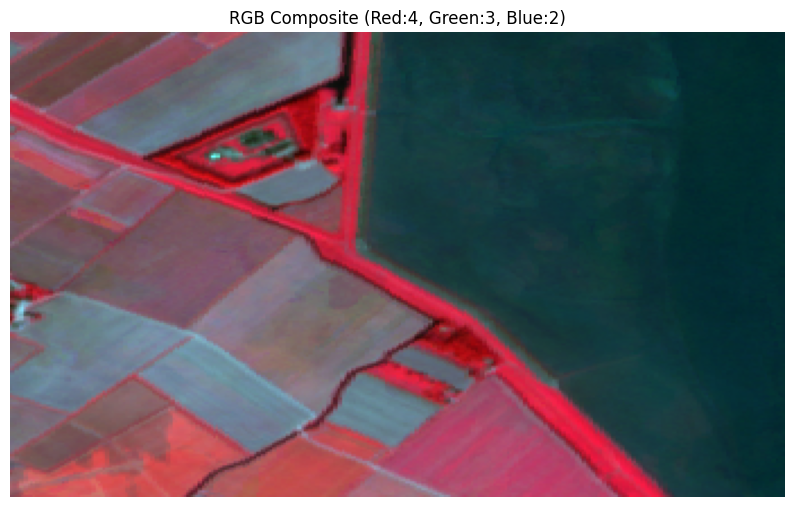

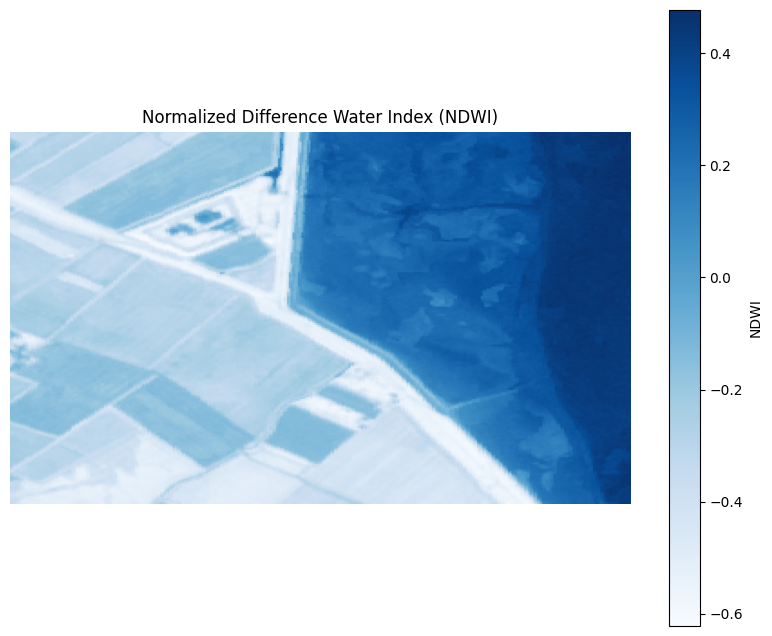

NDWI raster saved as ndwi.tif
Interactive NDWI map saved as death_valley_ndwi_map.html


In [4]:
# -------------------------
# Death Valley Ecosystem Analysis
# GIS with Python, Rasterio, GeoPandas, Folium
# -------------------------

# Install packages if needed
# (Uncomment these lines in Colab)
!pip install geopandas rasterio folium matplotlib numpy

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import calculate_default_transform, reproject
from shapely.geometry import Point, box
import matplotlib.pyplot as plt
import folium
import branca.colormap as cm

# -------------------------
# Load DEM (Death Valley region)
# -------------------------
!wget -q https://github.com/opengeos/datasets/releases/download/raster/dem_90m.tif -O dem.tif

dem_path = "dem.tif"
with rasterio.open(dem_path) as dem_src:
    print("DEM Metadata:", dem_src.meta)
    show(dem_src, cmap='terrain', title="DEM of Death Valley Region")

# -------------------------
# Reproject DEM to EPSG:4326 and save
# -------------------------
dst_crs = 'EPSG:4326'
reprojected_path = "reprojected_dem.tif"

with rasterio.open(dem_path) as src:
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds)
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    with rasterio.open(reprojected_path, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest)

print("Reprojected DEM saved as:", reprojected_path)

# Compare original vs reprojected
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
with rasterio.open(dem_path) as src:
    show(src, ax=axes[0], cmap='terrain')
    axes[0].set_title("Original DEM")
with rasterio.open(reprojected_path) as src:
    show(src, ax=axes[1], cmap='terrain')
    axes[1].set_title("Reprojected DEM (EPSG:4326)")
plt.show()

# -------------------------
# Load Multispectral Image (Death Valley area)
# -------------------------
!wget -q https://github.com/opengeos/datasets/releases/download/raster/cog.tif -O multispectral.tif

multi_path = "multispectral.tif"
with rasterio.open(multi_path) as multi_src:
    print("Multispectral image - Bands:", multi_src.count)
    print("CRS:", multi_src.crs)
    show((multi_src, 1), cmap='gray', title="Band 1 (Blue)")

# -------------------------
# Create RGB composite (Bands 4-3-2 -> RGB)
# -------------------------
with rasterio.open(multi_path) as src:
    red = src.read(4).astype(float)
    green = src.read(3).astype(float)
    blue = src.read(2).astype(float)

    # Normalize
    def normalize(band):
        return (band - band.min()) / (band.max() - band.min())
    rgb = np.dstack([normalize(red), normalize(green), normalize(blue)])

plt.figure(figsize=(10, 10))
plt.imshow(rgb)
plt.title("RGB Composite (Red:4, Green:3, Blue:2)")
plt.axis('off')
plt.show()

# -------------------------
# Compute NDWI (Water Index)
# -------------------------
with rasterio.open(multi_path) as src:
    green = src.read(2).astype(float) # Changed from band 3 to 2
    nir = src.read(4).astype(float)   # Changed from band 5 to 4

ndwi = (green - nir) / (green + nir + 1e-10)

plt.figure(figsize=(10, 8))
plt.imshow(ndwi, cmap='Blues')
plt.colorbar(label="NDWI")
plt.title("Normalized Difference Water Index (NDWI)")
plt.axis('off')
plt.show()

# Save NDWI
profile = src.meta.copy()
profile.update(dtype=rasterio.float32, count=1)
with rasterio.open("ndwi.tif", "w", **profile) as dst:
    dst.write(ndwi.astype(rasterio.float32), 1)

print("NDWI raster saved as ndwi.tif")

# -------------------------
# Make an interactive map highlighting NDWI
# -------------------------
# Simplified: use centroids and a folium image overlay or sample points
center_latlon = [36.5, -117]  # Approx center of Death Valley

m = folium.Map(location=center_latlon, zoom_start=8, tiles='cartodbpositron')

# Add an NDWI colormap legend
min_ndwi, max_ndwi = np.nanmin(ndwi), np.nanmax(ndwi)
colormap = cm.linear.Blues_09.scale(min_ndwi, max_ndwi)
colormap.caption = 'NDWI'
colormap.add_to(m)

# Example: plot random points colored by NDWI
rows, cols = ndwi.shape
for _ in range(200):
    r, c = np.random.randint(0, rows), np.random.randint(0, cols)
    value = ndwi[r, c]
    if np.isnan(value): continue
    # crude mapping to lat/lon (approx, for demonstration)
    lat = center_latlon[0] + (r - rows//2) * 0.001
    lon = center_latlon[1] + (c - cols//2) * 0.001
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        fill=True,
        fill_opacity=0.8,
        color=colormap(value)
    ).add_to(m)

m.save("death_valley_ndwi_map.html")
print("Interactive NDWI map saved as death_valley_ndwi_map.html")

# -------------------------
# DONE! You can upload .ipynb and data to GitHub.
# -------------------------